In [2]:
# Importing all modules
import sys
import scripts_raw_data.fetch_raw_data as r
import scripts_raw_data.map_team_names as b
import scripts_data_process.build_allStats_from1980 as p
import scripts_data_process.build_splits as bs
import train_models as t
import hyperparameters_tuning.greedy_forward_feature_selection as gf
import hyperparameters_tuning.greedy_backward_feature_selection as gb
import hyperparameters_tuning.hyperparameters_tuner as ht
import predict as pr

# HOML Project - NBA MVP Prediction
Eloi Beurtheret, Raphael Leonardi, Baptiste Pras

In case there is a problem with scrapping the data (or you don't want to do it). Here is the raw data from 1956 to 2025:

https://drive.google.com/file/d/13rUX1-7KhTlSInvkKfGZWQMO80OyLyAC/view?usp=sharing

## 1. Introduction

Every year at the end of the season, the NBA (National Basketball Association), the American league of basketball,
considered the best on Earth, elects the MVP (Most Valuable Player). The vote is taken by players and journalists,
who rank their top 10 best players. Each vote gives points, the player with the most points is elected best player of
the season (MVP).

We aimed to use the statistics of all players and the final team standings to predict the player that will be elected
MVP. This can be summarized as a classification task: predicting whether a player is the MVP or is not.
It is a highly imbalanced problem. Recent years have had about 450+ players each season, for only one player elected
MVP, and therefore only one player must be predicted MVP during inference.

A similar problem was tackled on Kaggle 4 years ago, using a Linear Regression and a Random Forest (https://www.kaggle.com/code/vivovinco/nba-stats-mvp-prediction). We decided to tackle the problem differently here.

Our code is heavy and contain many modules. To help with training and keeping a clean code, we decided to code in .py files. Therefore, this notebook will explain our steps in the project, describe our choices and results, and just import our modules and launch them with the good parameters and an explanation of the parameters. There is no real code in this notebook beside the Appendix A with the plots.

_____________________________________
## 2. Preprocessing

### 2.1. Data Scrapping and Cleaning

We scraped all the data needed from the website https://www.basketball-reference.com/ with a custom script. This
website displays players statistics since 1956. Though it has more statistics (features) starting in 1980 (some statistics
didn’t exist / weren’t traced before this year). Note that we changed the script several times because the website keeps changing their anti-scrapping protection. Therefore the scrapping script might need some modifications. Use a VPN if you get temp-ban from connecting to this website. 

The scrapped data is saved in `raw_data\raw_player_csv\` and `raw_data\raw_standings_csv\` with one csv per year.

We added to each player a feature by adding his team's final rank during the season. We collected this data by scrapping the standing on the website for each season, and mapping each row to the correct rank by grouping by year and team of the players. We added a manual mapping table for some team names that were inconsistent between the player data and the standings.

For the data, we encoded the position of the player (position on the field, such as ”P”, ”PF” etc.) as a one hot
vector. We also transformed a feature which is the Win-Loss ratio, using the format ”XX-YY” with XX the number
of victories of the player’s team during the season, and YY the number of losses. We encoded it as an integer giving
the difference, doing XX - YY. This number is a positive, negative or null integer.

Finally, we normalized all numerical values to [0, 1] for each season, to account for the fact that the NBA style
changed and that 30 points today might not be as rare as it used to be 40 years ago for instance. See Fig 1 to see
why we decided to normalize. We chose a normalization by scaling all values between the min and max values of the feature for the given season.

We then built 4 datasets (called pipeline):
- **allStats_from1956**: all features from 1956 (19 features after preprocessing, 23 988 instances)

- **selectedStats_from1956**: arbitrary (we selected the statistics we thought were taken into consideration by humans to elect the MVP) selected features from 1956 (12 features after preprocessing, 23 988 instances)

- **allStats_from1980**: all features from 1980 (32 features after preprocessing, 19 944 instances)

- **selectedStats_from1980**: arbitrary selected features from 1980 (14 features after preprocessing, 19 944 instances)

When we use the stats from 1956, to avoid NaN in the dataset between 1956 and 1979, we don’t collect the statistics
that are available starting in 1980 but not before.

We use as label vector y_top1.csv, with binary labels, 0 if the player was not elected MVP, 1 if he was.
We also keep another label vector y_top10.csv where we keep the rank at the election of the MVP (1 to 10, -1 if the player wasn’t
ranked in the election, or if the data is missing), this label is only used for inference at this point of the project.

These processed datasets are saved in `processed_data\<dataset name>\<year>\` with one repository per year for each dataset, and each year containing `Data.csv`, the name of the players in `Name.csv` and both `y_top1.csv` and `y_top10.csv`. 

The figure below shows the distribution of some stats (points, 3 points made, games played) in 1980, 2000 and 2025, highlighting the
need of normalization per season.

![Figure 1](images/mvp_stats_distributions.png)


In [3]:
# Dowloading raw data from online sources (1980-2025)
# r.main(start_year: int, end_year: int)
r.main(1980, 2025)



[INFO] Downloading per-season raw data
[INFO] Downloading season 1980 from https://www.basketball-reference.com/leagues/NBA_1980_per_game.html...
[SKIP] Skipping season 1980, file already exists.
[INFO] Downloading season 1981 from https://www.basketball-reference.com/leagues/NBA_1981_per_game.html...
[SKIP] Skipping season 1981, file already exists.
[INFO] Downloading season 1982 from https://www.basketball-reference.com/leagues/NBA_1982_per_game.html...
[SKIP] Skipping season 1982, file already exists.
[INFO] Downloading season 1983 from https://www.basketball-reference.com/leagues/NBA_1983_per_game.html...
[SKIP] Skipping season 1983, file already exists.
[INFO] Downloading season 1984 from https://www.basketball-reference.com/leagues/NBA_1984_per_game.html...
[SKIP] Skipping season 1984, file already exists.
[INFO] Downloading season 1985 from https://www.basketball-reference.com/leagues/NBA_1985_per_game.html...
[SKIP] Skipping season 1985, file already exists.
[INFO] Downloadin

In [ ]:
# Building a mapping file for team names 
# Build a mapping file to standardize team names across dataset

# b.main()
b.main()


[INFO] Building team abbreviation mapping
Scanning player CSVs for team IDs: 100%|██████████| 46/46 [00:00<00:00, 271.53it/s]
[WARN] Unknown team abbreviations not found on site: ['2TM', '3TM', '4TM', '5TM', 'BRK', 'CHH', 'CHO', 'KCK', 'NOK', 'NOP', 'SDC', 'SEA', 'VAN', 'WSB']
[ERROR] Run merge_team_mapping() to resolve them.
[DONE] Saved mapping to c:\Users\cleme\Eloi\Code\HoML\Projet-Homl\raw_data\team_id_to_name.csv

[INFO] Fetching missing teams from historical_teams.csv
[DONE] Merged mapping saved to c:\Users\cleme\Eloi\Code\HoML\Projet-Homl\raw_data\team_id_to_name.csv

[INFO] Checking for missing teams
Checking player team IDs: 100%|██████████| 46/46 [00:00<00:00, 279.42it/s]
[DONE] All team abbreviations in player stats are mapped.
Checking standings team names: 100%|██████████| 46/46 [00:00<00:00, 537.74it/s]
[DONE] All full team names in standings are mapped.

[INFO] Checking for duplicate team IDs
[DONE] No duplicate Team ID found in the mapping.

[INFO] Checking mapping
Va

In [ ]:
# Cleaning data and building dataset for each year from 1980 to 2025 
# Clean raw data and builds datasets with by specifying start and end year

# p.main(start_year: int, end_year: int)
p.main(1980, 2025)

[INFO] Running pipeline from 1980 to 2025...

[INFO] Processing the raw data to per-season cleaned data
Creating per-season cleaned data: 100%|██████████| 46/46 [00:05<00:00,  8.98it/s]
[DONE] Saved per-season data to c:\Users\cleme\Eloi\Code\HoML\Projet-Homl\processed_data\allStats_from1980

[INFO] Filling missing values for per-season data
Imputing missing values with KNN: 100%|██████████| 46/46 [00:01<00:00, 25.55it/s]
[DONE] Finished filling missing values.

[INFO] Normalizing per-season data
Normalizing cleaned stats: 100%|██████████| 46/46 [00:01<00:00, 28.46it/s]
[DONE] Finished normalization.

[INFO] Verifying processed data integrity
Validating per-season files: 100%|██████████| 46/46 [00:00<00:00, 59.78it/s]
[DONE] Finished checking processed data integrity.


### 2.2. Preparing Dataset for Training

To train the models, since the problem is highly imbalanced, we used a Leave-One-Season-Out strategy (LOSO). We created
N-1 datasets where N is the number of seasons. Each fold contains a training set with all seasons except one, and a test set with one season. That way, we had enough training data, and we got to evaluate on each season if
the model is able to predict the true MVP or not. This accounts for the fact that we should predict the MVP for one season only, and can't infer on multiple seasons at once.

We therefore had 46 splits for datasets starting in 1980, and 70 splits for the ones starting in 1956. After training
some models, we noticed that all1980 dataset always maximizes the performances, we therefore only kept this one
for the rest of the project, to avoid too high computational cost.

These splits are saved under `datasets\<dataset name>\<year>` with one repository per year (the given year is the one isolated from others in the split for training). Each year contains two repositories: `test\` with `Name.csv` and `test.npz` the compressed data, and `train\` with `Name.csv` and `train.npz` the compressed data. After this point of the project, `raw_data\` and `processed_data\` can be deleted to free storage space. 

In [ ]:
# Creating train and test splits with LOSO strategy 
# Create splits for each dataset from 1980 to 2025 by specifying 
# dataset names, start year, and end year

# bs.main(dataset_names: list[str], start_year: int, end_year: int)
bs.main(["all1980"], 1980, 2025)


[INFO] Creating LOSO splits for pipeline 'allStats_from1980' from 1980 to 2025...

[INFO] Creating leave-one-season-out splits for pipeline 'allStats_from1980'
Building LOSO splits: 100%|██████████| 46/46 [00:19<00:00,  2.40it/s]
[DONE] Finished creating LOSO splits for pipeline 'allStats_from1980'
[INFO] Checking LOSO splits for pipeline 'allStats_from1980' from 1980 to 2025...

[INFO] Checking LOSO splits integrity for pipeline 'allStats_from1980'
Checking splits: 100%|██████████| 46/46 [00:02<00:00, 22.11it/s]
[DONE] All LOSO splits are consistent for pipeline 'allStats_from1980'

[INFO] All selected pipelines finished.


### 2.3. Feature Selection

To maximize performance, we perform different kind of feature selections. We design a
greedy forward and a greedy backward feature selection. The forward feature selection just starts with no feature,
and train one model per feature, it then keeps the feature that improved the most the accuracy. It then trains more
models with the selected feature and all the other ones, one after one. When the accuracy doesn’t improve for too
many iterations, we stop the search. The backward is the same algorithm, but starts with all features and remove
the least important one (the one that minimizes the score of the model if kept). We used the Recall@1 metric for
the feature selection (see Section 4.1). See Fig 2 for some results.

We also coded a feature selection that test all possibilities of features, but running it would require training over a
billion models (32 choose k, with k ranging from 1 to 32), which isn't possible nor a good practice.

The best features for each models are:

- Logistic Regression: ["Team Overall", "G", "MP", "FGA", "FG%", "3P", "FT", "FT%", "ORB", "DRB", "BLK", "PF", "AST"]


- XGBoost: ["Team Overall", "PTS", "TOV", "GS", "MP", "2PA", "3PA", "FT"]


- Random Forest:  ["2P", "Team Overall", "PTS", "G", "TOV", "FT%", "PF"]

We save in `hyperparameters_tuning\greedy_rfe_results\<method name>_<model name>_<dataset name>\` under .txt files the best features and the best score associated, and save a `best_support_mask.npy` to easily apply the feature selection.

The figure below shows scores before and after feature selection for our three models.

![Figure 2](images/model_performance_comparison.png)

In [ ]:
# Greedy forward feature selection 
# Run the greedy forward feature selection by specifying 
# the dataset(s), the model, and patience (number of iterations without improvement before stopping)

# gf.main(dataset_names: list[str], model: str, patience: int)
gf.main(["all1980"],  "logreg", 2)

In [ ]:
# Greedy backward feature selection 
# Run the greedy backward feature selection by specifying 
# the dataset(s), the model, and patience (number of iterations without improvement before stopping)

# gb.main(dataset_names: list[str], model: str, patience: int)
gb.main(["all1980"],  "logreg", 2)

_____________________________________
## 3. Training Models

We train several models : a Logistic Regression, as it is one of the simplest model for such data. We also try a
Random Forest and XGBoost, since trees can handle tabular data and gradient boosting based models tend to be
the best in such tasks. We allow the code to be ran with different models in plug-in, but only evaluate these three
models.

To get the prediction of the MVP, we train each model to give a probability for each player of being elected MVP, and we predict the
MVP as the player with the biggest probability using argmax. This also gives us a full ranking of the most probable players to win MVP.

At this point of the project, we train on default hyperparameters, with the feature selection already made.

Each model trained is saved under `models\<model name>_<dataset name>\`. We save the global results of the model under `mean_summary.csv` and the full results per split under `summary_results.csv`. We also save in the repository `checkpoints\` the weights of the model for each split of the LOSO dataset. 

### 3.1. Models

#### 3.1.1. Logistic Regression

Logistic Regression is used as our baseline model to establish a minimum level of performance. As a linear model, it
estimates the probability of being the MVP by using the logistic function to model the relationship between player
features and the target variable. The model is trained by minimizing the cross-entropy loss function. Its simplicity
provides an essential context for evaluating the added value of the more complex tree-based models. Note that for
some seasons, logreg tended to not converge after thousands of iterations, and training this model took a long time.

#### 3.1.2. eXtreme Gradient Boosting

We selected XGBoost (eXtreme Gradient Boosting) as the primary gradient boosting model due to its superior
performance observed during preliminary testing, outperforming alternatives such as LightGBM and HistGradientBoostingClassifier that we also tried. This sequential ensemble learning algorithm constructs decision trees where
each new tree aims to correct the residual errors of the previous models. It is particularly effective for tabular data
thanks to its good loss function optimization and the integration of regularization techniques to minimize overfitting.

#### 3.1.3. Random Forest

The Random Forest is chosen as a powerful ensemble model based on the Bagging principle. It simultaneously builds
numerous independent decision trees on random subsets of the data and features. Final predictions are obtained by
averaging the probabilities from these trees, which effectively reduces the model’s variance. This makes it particularly
robust to noise and overfitting, offering an excellent balance between stability and high performance.

In [ ]:
# Training models with selected features and default hyperparameters
# Run training for each model specifying the model name

# t.main(model: str)
models=["logreg", "xgb", "rf"]
for model in models:
    t.main(model=model)

### 3.2. Hyperparameters tuning

To maximize performances, we then trained the hyperparameters of our models. For this, we designed a module to
pass a list of values to test for a given hyperparameter and model, and trained the said model with all given values,
and default hyperparameters for other ones. This is similar to a grid search, but without considering interactions
between hyperparameters, and treating them all separably. The results are displayed in an HTML file for easy
comparison of which one is better (since we have several metrics) and can’t evaluate on just a single metric (see
Section 4.1). See Fig 3 for some example of the final HTML file.

The results are saved under HTML files named `<model name>_<hyperparameter name>.html` in the repository `hyperparameters_tuning\results`.

The best hyperparameters for each models are:

- Logistic Regression: {"solver": "saga", "penalty": "l2", "class_weight": None, "max_iter": 50000, "C": 5.0}


- XGBoost: {"n_estimators": 100, "learning_rate": 0.1, "max_depth": 4, "scale_pos_weight": 5, "use_label_encoder": False, "eval_metric": "logloss", "random_state": 42}


- Random Forest: {"n_estimators": 750, "max_depth": 15, "class_weight": None, "min_samples_leaf": 2, "random_state": 42}


The figure below shows what an hyperparameter training report looks like, and hint on how we chose which hyperparameter best fits.

![Figure 3](images/hyperparameters_tuning.png)

In [ ]:
# Hyperparameter tuning
# Run hyperparameter tuning by specifying 
# the model, hyperparameter to tune, the list of values to try,
# several hyperparameters to test at once (combo), 
# and whether to use all features (full) or only selected features

# ht.main(model: str, hyperparameter: str, values: list, combo: dict, full: bool)
ht.main("logreg", "C", [1, 2, 3, 4, 5], combo={}, full=False)

_____________________________________
## 4. Evaluation

### 4.1. Metrics

Due to the complexity of the task (predicting one player among several hundreds) and to the output we have (one
probability of being elected MVP per player), we decided to look at different metrics to evaluate and compare the
models (note that for all metrics, we use k ∈ [1, 3, 5, 10]):

- **recall@k**: this is the main metric, it evaluates whether the True MVP was predicted amongst the first-k most
probable players to win MVP. For instance, if l = 1, and the predicted MVP is not the true MVP, the accuracy
is 0.0 (recall@k is either 1 or 0). This is supposed to be the most informative metric on whether our model can
predict or not the MVP.

- **precision@k (top-k)**: this metric evaluates whether the top-k predicted players really are in the top-k. For
instance, if we have k = 5, if 4 players predicted in our top 5 are in the true top 5, and one is out, therefore the
accuracy is 0.8. This is the hardest metric of all, high performance in this metric isn’t expected as we trained
our model to predict the MVP, not the top-k.

- **precision@k (top-10)**: this metric evaluates whether the top-k predicted players are in the top 10. For instance,
if k = 3 and our top 3 predicted players all are in the real top 10, the accuracy is 1.0. This is a lenient version
of the previous one.

- **mean abs rank error@k (MARE@k)**: this metric evaluates the position difference for each player in our top k
compared to its true position. For instance, if k = 1, and the predicted top player ranked 4 in the election, the
value is 3. If we don’t have an information on the true rank at the election for a predicted player (out of top
10 or missing information), we consider his rank to be 11.

- **mean / min / max true MVP rank**: this metric evaluates the position predicted for the true MVP. The min is
the best position predicted for a true MVP (1 being the minimum), max is the worst position predicted for a
true MVP, and mean is the average of the predictions for all MVPs.

### 4.2. Results

In this section, we discuss the performance of our model, see the repository `models\` and look at the `mean_summary.csv` file for each model to see the full numbers.

#### 4.2.1. Logistic Regression

The Logistic Regression achieved the best performances, with a recall@1 of 0.826, and a recall@3 of 1.0, meaning
that this model correctly predicts the MVP 82,6% of the time, and always correctly classify the true MVP in its top
3. The average rank predicted for the true MVP is 1.26, with a maximum of rank 3 predicted and got the lowest
MARE, with for instance a mean absolute rank error@1 of 0.261, which means that the prediction is in average 0.261
place wrong (which is good).

It also achieves the best precision@k with over 80% for k=1, and almost consistently over 70% for other values of k.
It also enjoys the best precision@10 of all models.

With these results, we can safely say that the Logistic Regression is the best model to predict the MVP, and also to
give a ranking of the most probable players to win MVP title.

#### 4.2.2. eXtreme Gradient Boosting

While XGBoost was our biggest hope for the best performance, it achieved the same accuracy than the Logistic
Regression for recall@1 with 0.862, but only achieved 0.87 for recall@3, 0.913 for recall@5 and 0.978 for recall@10,
while the Logistic Regression was at 1.0 for all k ¿= 3. The average rank predicted for the true MVP was 1.76, with
a maximum of 11, making it worse than Random Forest for these stats. For the MARE, the mean absolute rank
error@1 was 0.739.

It achieved a precision@k and precision@10 consistently lower than the Logistic Regression, but also over the accuracy
of Random Forest, except for k = 3.

These results show that while XGBoost is as good as the Logistic Regression for the sole purpose of predicting the
MVP, when the model is wrong, it makes biggest mistakes, and this model is less good to give a ranking of the
players (because of the lower precision).

#### 4.2.3. Random Forest

Random Forest was the last model we tried, and we tried it to see something different, but it didn’t compete with
the Logistic Regression nor XGBoost. It achieved a recall@1 of 0.717, and a recall@3 of 0.935, recall@5 of 0.957 and
recall@10 of 1.0. The average rank predicted for the true MVP was 1.61, with a maximum of 6, meaning the errors,
when made, are more frequent than for XGBoost, but also smaller. For the MARE, the mean absolute rank error@1
was 0.978, making it the worst model it terms of mean error around the true MVP.

It also achieved the worst precision@k and precision@10, except for k = 3, where it surpassed XGBoost.

These results make Random Forest the least fit model for our task, with over 0.1 points under the others for MVP
prediction, and also being worse at predicting a ranking of most probable players to win MVP.

The figure below visually present the performance report of our 3 models.

![Figure 4](images/performance_comparison_v2.png)

_____________________________________
## 5. Conclusion

In conclusion, our best model was the Logistic Regression, at least compared to Random Forest and Gradient Boosting
methods. It achieved an accuracy of 0.826, meaning that 82.6% of the time, the predicted MVP was correct. It also
achieved over 80% precision for predicting the top 10 players who are the most probable to win the MVP title.

The models worked well, but we were set back by the lack of good results while using other gradient boosting methods
such as lightGBM or HistGradientBoosting. We also think that because of the type of the task, only using statistics
doesn’t allow perfect accuracy. Indeed, the MVP is elected by journalists and players, there is therefore a human
parameter we don’t account for. For instance, Nikola Jokic or LeBron James were MVP worthy once, but didn’t win
it because they had won it 3 times in a row already, and journalists didn’t want spectators to lose interest by getting
the same MVP again. A way to account for these parameters would be to include the historic of the MVP over the
past years in the training. We could also scrap some data online, and treat it as an NLP task, to account for players
popularity, because a player might be really good, but could make controversial political statements or have a bad
behavior, and therefore would lack support in the votes.

The biggest challenge in-fine was the web scrapping as the website kept changing their protection

If we had more time, such implementations could be added, and more time could be spent on training the hyperparameters to refine them (hyperparameters, feature selection, different standardisation). We thought about, instead
of standardizing by taking the min and max value of a feature for a given season, computing the difference to the
mean, which is a different standardization and could give different performances.

Finally, we scrap the data from the current 2025-2026 season that started 2 months ago, we train our best model (Logistic Regression) on the years 1980 to 2025 (included), and we infer the predicted MVP at this point of the season.

In [ ]:
# Scrap the data for 2026, build dataset and split
r.main(2026, 2026)
p.main(2026, 2026)
bs.main(["all1980"], 1980, 2026)



[INFO] Downloading per-season raw data
[INFO] Downloading season 2026 from https://www.basketball-reference.com/leagues/NBA_2026_per_game.html...
[SKIP] Skipping season 2026, file already exists.
[DONE] Saved raw data to c:\Users\cleme\Eloi\Code\HoML\Projet-Homl\raw_data\raw_player_csv

[INFO] Downloading expanded standings for each season
[INFO] Downloading expanded standings for 2026...
[OK] Found in comment and saved for 2026
[DONE] Saved raw data to c:\Users\cleme\Eloi\Code\HoML\Projet-Homl\raw_data\raw_standings_csv

[INFO] All requested downloads finished.
[INFO] Running pipeline from 2026 to 2026...

[INFO] Processing the raw data to per-season cleaned data
Creating per-season cleaned data: 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]
[DONE] Saved per-season data to c:\Users\cleme\Eloi\Code\HoML\Projet-Homl\processed_data\allStats_from1980

[INFO] Filling missing values for per-season data
Imputing missing values with KNN: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]
[DONE] 

In [5]:
# Predict the MVP for the 2026 season using our best model

# pr.main(pipeline: str, model: str, year: int, verbose: bool)
pr.main("all1980", model="logreg", year=2026)


[INFO] Loading LOSO split for year 2026...


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\cleme\\Eloi\\Code\\HoML\\Projet-Homl\\datasets\\allStats_from1980\\2026\\train\\train.npz'

_____________________________________
## Appendix A. Code for Data Visualization and Plots

We used a notebook for data visualization and plots, so we report this notebook here.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from matplotlib.patches import Patch

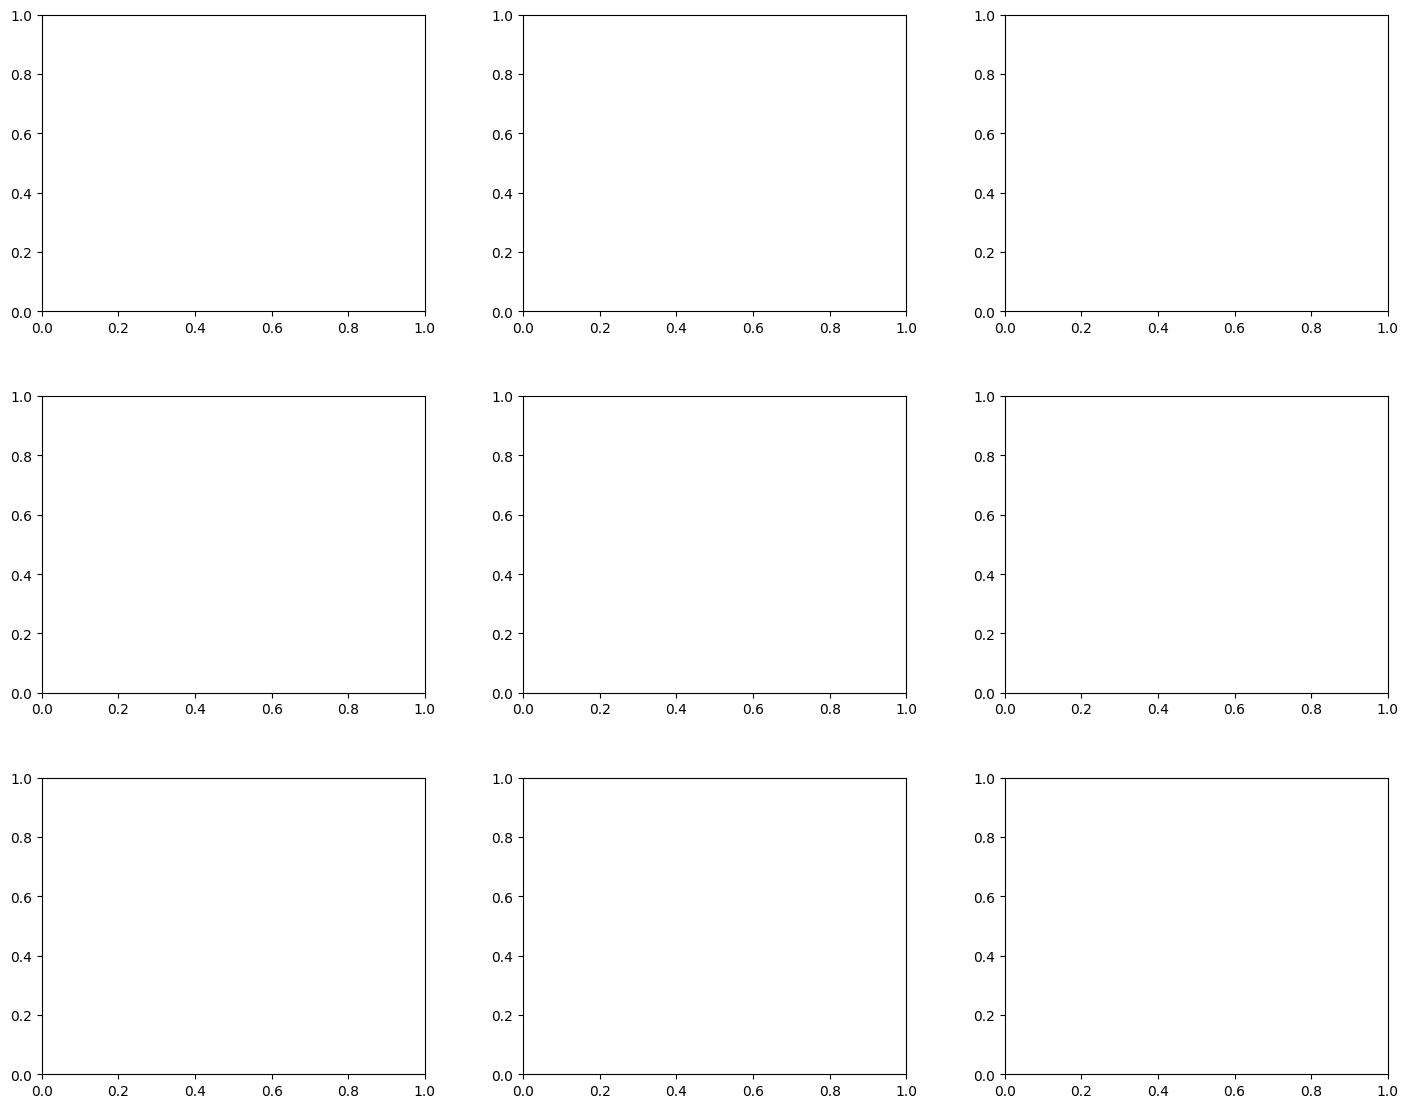

In [5]:
# Trends per year analysis for some stats with MVP highlighting

BASE_DIR = os.path.join(os.getcwd(), 'raw_data', 'raw_player_csv')
YEARS_TO_ANALYZE = [1980, 2000, 2025]
STATS_TO_PLOT = ['PTS', '3P', 'G']

data_frames = {}
mvp_data = {}

for year in YEARS_TO_ANALYZE:
    file_name = f"NBA_{year}_per_game.csv"
    file_path = os.path.join(BASE_DIR, file_name)
    if not os.path.exists(file_path):
        continue
    df = pd.read_csv(file_path)
    
    df_cleaned = df.copy()
    df_cleaned[STATS_TO_PLOT] = df_cleaned[STATS_TO_PLOT].fillna(0)
    
    # Correction de l'expression régulière: cherche 'MVP-1' comme un mot complet (\b)
    mvp_df = df_cleaned[df_cleaned['Awards'].astype(str).str.contains(r'\bMVP-1\b', na=False, regex=True)]
    
    if mvp_df.empty:
        data_frames[year] = df_cleaned
        mvp_data[year] = None
        continue
    current_mvp_data = mvp_df.iloc[0]
    
    data_frames[year] = df_cleaned
    mvp_data[year] = current_mvp_data

fig, axes = plt.subplots(len(YEARS_TO_ANALYZE), len(STATS_TO_PLOT), 
                         figsize=(5 * len(STATS_TO_PLOT), 4 * len(YEARS_TO_ANALYZE)))
fig.tight_layout(pad=4.0)
if len(YEARS_TO_ANALYZE) == 1:
    axes = axes.reshape(1, -1)
if len(STATS_TO_PLOT) == 1:
    axes = axes.reshape(-1, 1)

for i, year in enumerate(YEARS_TO_ANALYZE):
    if year not in data_frames:
        continue
    df = data_frames[year]
    mvp = mvp_data[year]
    for j, stat in enumerate(STATS_TO_PLOT):
        ax = axes[i, j]
        
        mean_value = df[stat].mean()
        
        ax.hist(df[stat], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
        
        ax.axvline(mean_value, color='red', linestyle='--', linewidth=1.5, 
                   label=f'Mean: {mean_value:.1f}')
        
        if mvp is not None:
            mvp_value = mvp[stat]
            mvp_name = mvp['Player']
            
            ax.axvline(mvp_value, color='green', linestyle='-', linewidth=2.5, 
                       label=f'MVP ({mvp_name}): {mvp_value:.1f}')
            
            ax.annotate(f'MVP', 
                        xy=(mvp_value, ax.get_ylim()[1] * 0.8),
                        xytext=(-5, 5), textcoords='offset points', 
                        ha='right', va='center', color='darkgreen', fontsize=9, 
                        arrowprops=dict(facecolor='darkgreen', shrink=0.05, width=1, headwidth=5))
            
        ax.set_title(f'Distribution of {stat} in {year}', fontsize=12)
        ax.set_xlabel(stat, fontsize=10)
        ax.set_ylabel('Number of Players', fontsize=10)
        ax.legend(loc='upper right')
        ax.grid(axis='y', alpha=0.5)
plt.savefig('images/mvp_stats_distributions.png', dpi=300)    
plt.show()


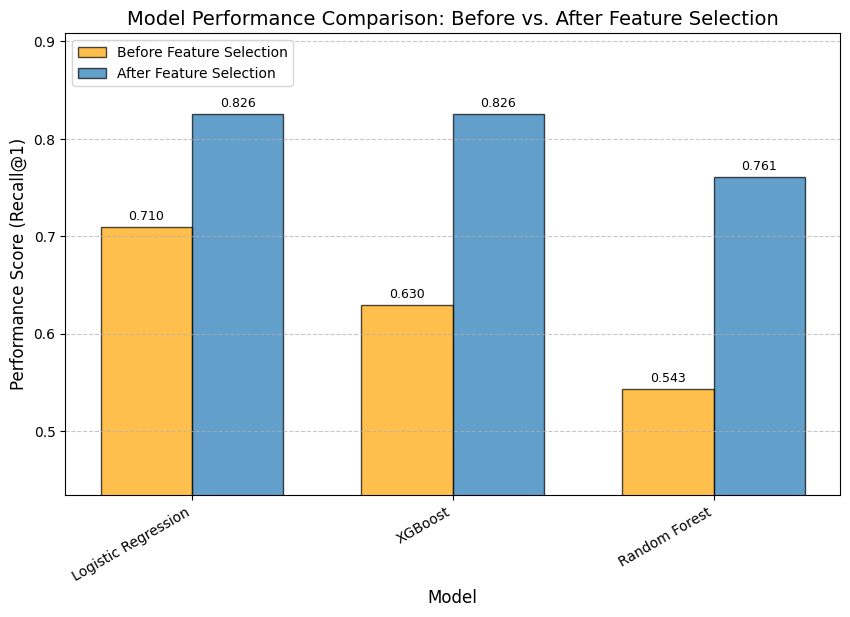

In [6]:
# Model performance comparison before and after feature selection

models = ["Logistic Regression", "XGBoost", "Random Forest"]
performance_before_fs = [0.710, 0.630, 0.543] 
performance_after_fs = [0.826, 0.826, 0.761] 

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, performance_before_fs, width, label='Before Feature Selection', color='orange', edgecolor='black', alpha=0.7)
rects2 = ax.bar(x + width/2, performance_after_fs, width, label='After Feature Selection', color='tab:blue', edgecolor='black', alpha=0.7)

ax.set_ylabel('Performance Score (Recall@1)', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.set_title('Model Performance Comparison: Before vs. After Feature Selection', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30, ha="right")
ax.legend(loc='upper left')
ax.set_ylim(min(performance_before_fs + performance_after_fs) * 0.8, 
            max(performance_before_fs + performance_after_fs) * 1.1)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('images/model_performance_comparison.png', dpi=300)
plt.show()

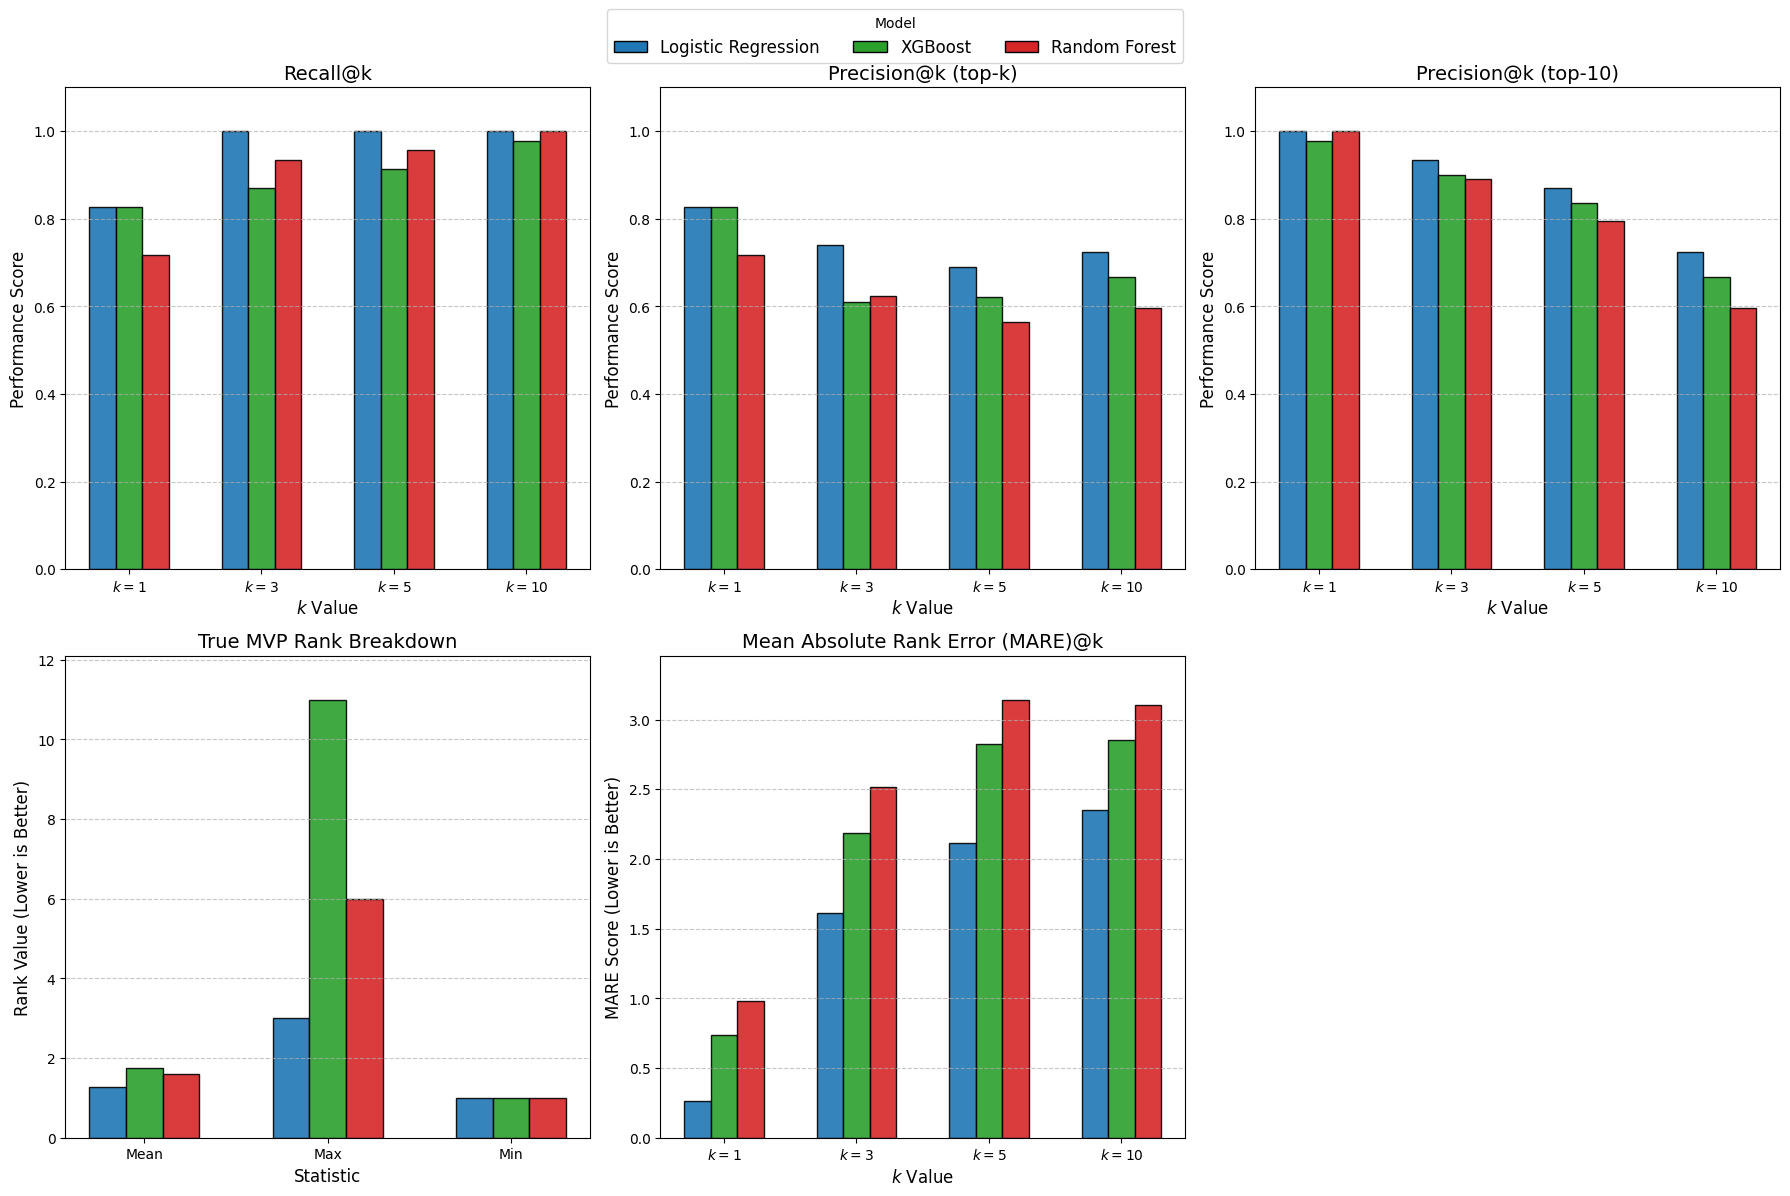

In [7]:
# Detailed performance metrics comparison across models and k values

models = ["Logistic Regression", "XGBoost", "Random Forest"]
k_values = [1, 3, 5, 10]
n_models = len(models)
n_k = len(k_values)
width = 0.20

recall_data = {
    "Logistic Regression": [0.826, 1.0, 1.0, 1.0],
    "XGBoost": [0.826, 0.87, 0.913, 0.978],
    "Random Forest": [0.717, 0.935, 0.957, 1.0]
}

precision_topk_data = {
    "Logistic Regression": [0.826, 0.739, 0.691, 0.725],
    "XGBoost": [0.826, 0.609, 0.622, 0.666],
    "Random Forest": [0.717, 0.623, 0.565, 0.596]
}

precision_top10_data = {
    "Logistic Regression": [1.0, 0.935, 0.87, 0.725],
    "XGBoost": [0.978, 0.899, 0.835, 0.666],
    "Random Forest": [1.0, 0.891, 0.796, 0.596]
}

performance_metrics = [
    (recall_data, 'Recall@k'),
    (precision_topk_data, 'Precision@k (top-k)'),
    (precision_top10_data, 'Precision@k (top-10)')
]

model_colors = {'Logistic Regression': 'tab:blue', 'XGBoost': 'tab:green', 'Random Forest': 'tab:red'}

mvp_rank_data = {
    "Logistic Regression": {"Mean": 1.28, "Max": 3.0, "Min": 1.0},
    "XGBoost": {"Mean": 1.76, "Max": 11.0, "Min": 1.0},
    "Random Forest": {"Mean": 1.61, "Max": 6.0, "Min": 1.0}
}
mvp_rank_metrics = ["Mean", "Max", "Min"]
n_mvp_metrics = len(mvp_rank_metrics)

mare_data = {
    "Logistic Regression": [0.261, 1.609, 2.117, 2.352],
    "XGBoost": [0.739, 2.188, 2.826, 2.857],
    "Random Forest": [0.978, 2.514, 3.143, 3.104]
}

max_mare_value = max(max(v) for v in mare_data.values())

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

x = np.arange(n_k)
offsets = np.linspace(-width, width, n_models)

for i, (data_dict, title) in enumerate(performance_metrics):
    ax = axes[0, i]

    for j, model in enumerate(models):

        pos = x + offsets[j]

        performance_values = data_dict[model]

        ax.bar(
            pos,
            performance_values,
            width,
            label=model,
            color=model_colors[model],
            edgecolor='black',
            alpha=0.9
        )

    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Performance Score', fontsize=12)
    ax.set_xlabel('$k$ Value', fontsize=12)

    ax.set_xticks(x)
    ax.set_xticklabels([f'$k={val}$' for val in k_values])

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 1.1)

ax_mvp_rank = axes[1, 0]
x_mvp = np.arange(n_mvp_metrics)
offsets_mvp = np.linspace(-width, width, n_models)
max_rank = max(max(d.values()) for d in mvp_rank_data.values())

for j, model in enumerate(models):
    pos_mvp = x_mvp + offsets_mvp[j]
    mvp_values = [mvp_rank_data[model][metric] for metric in mvp_rank_metrics]

    ax_mvp_rank.bar(
        pos_mvp,
        mvp_values,
        width,
        label=model,
        color=model_colors[model],
        edgecolor='black',
        alpha=0.9
    )

ax_mvp_rank.set_title('True MVP Rank Breakdown', fontsize=14)
ax_mvp_rank.set_ylabel('Rank Value (Lower is Better)', fontsize=12)
ax_mvp_rank.set_xlabel('Statistic', fontsize=12)
ax_mvp_rank.set_xticks(x_mvp)
ax_mvp_rank.set_xticklabels(mvp_rank_metrics)
ax_mvp_rank.grid(axis='y', linestyle='--', alpha=0.7)
ax_mvp_rank.set_ylim(0, max_rank * 1.1)

ax_mare = axes[1, 1]
x_mare = np.arange(n_k)
offsets_mare = offsets

for j, model in enumerate(models):
    pos_mare = x_mare + offsets_mare[j]
    mare_values = mare_data[model]

    ax_mare.bar(
        pos_mare,
        mare_values,
        width,
        label=model,
        color=model_colors[model],
        edgecolor='black',
        alpha=0.9
    )

ax_mare.set_title('Mean Absolute Rank Error (MARE)@k', fontsize=14)
ax_mare.set_ylabel('MARE Score (Lower is Better)', fontsize=12)
ax_mare.set_xlabel('$k$ Value', fontsize=12)
ax_mare.set_xticks(x_mare)
ax_mare.set_xticklabels([f'$k={val}$' for val in k_values])
ax_mare.grid(axis='y', linestyle='--', alpha=0.7)
ax_mare.set_ylim(0, max_mare_value * 1.1)

axes[1, 2].axis('off')

model_handles = [Patch(facecolor=model_colors[model], edgecolor='black', label=model) for model in models]

fig.legend(
    handles=model_handles,
    loc='upper center',
    ncol=n_models,
    bbox_to_anchor=(0.5, 1.0),
    title='Model',
    fontsize=12
)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('images/performance_comparison_v2.png', dpi=300)
plt.show()